In [2]:
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
import pandas as pd 
import pickle 
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
import os 
from matplotlib.image import imread 
import random
from PIL import Image
import tensorflow as tf 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D

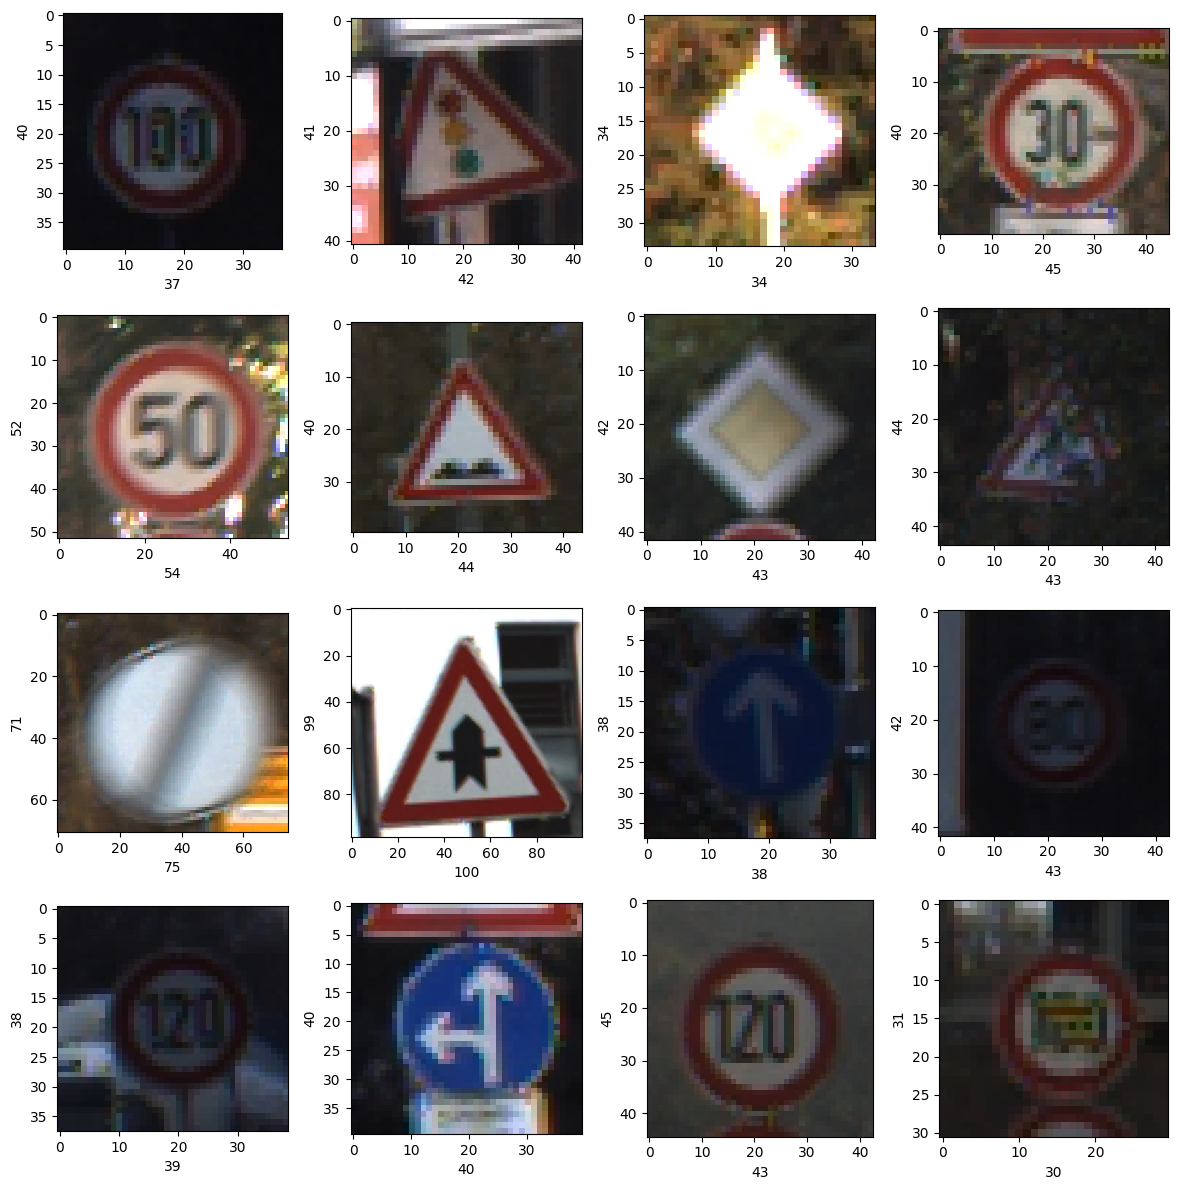

In [4]:
plt.figure(figsize=(12, 12))
path = 'archive/Test'
for i in range(1, 17):
    plt.subplot(4, 4, i)
    plt.tight_layout()
    rand_img = imread(path + '/' + random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize=10)
    plt.ylabel(rand_img.shape[0], fontsize=10)

In [5]:
dim1 = []
dim2 = []

for i in range(1, 23):
    labels = 'archive/Train' + '/{0}'.format(i)
    img_path = os.listdir(labels)
    for x in img_path:
        img = imread(labels + '/' + x)
        dim1.append(img.shape[0])
        dim2.append(img.shape[1])

In [6]:
print("Dimension 1 mean: ", np.mean(dim1))
print("Dimension 2 mean: ", np.mean(dim2))

Dimension 1 mean:  49.59264919941776
Dimension 2 mean:  49.89679767103348


In [7]:
### Reshape the images to (50, 50)
images = []
labels_id = []

for i in range(43):
    labels = 'archive/Train' + '/{0}'.format(i)
    img_path = os.listdir(labels)
    for x in img_path:
        img = Image.open(labels + '/' + x)
        img = img.resize((50, 50))
        img = np.array(img)
        images.append(img)
        labels_id.append(i)   

In [8]:
## Converting images into numpy array
images = np.array(images)
images = images / 255
images.shape

(39209, 50, 50, 3)

In [9]:
labels_id = np.array(labels_id)
labels_id.shape

(39209,)

In [11]:
## Visualize the number of classes count 
label_counts = pd.DataFrame(labels_id).value_counts()
label_counts.head()

0 
2     2250
1     2220
13    2160
12    2100
38    2070
Name: count, dtype: int64

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, 
                                                    labels_id, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [13]:
## Build-in function for one-hot-encoding equal Keras
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_test)

In [15]:
model = Sequential()

model.add(Conv2D(filters = 64, 
                 kernel_size = (3,3), 
                 input_shape = X_train.shape[1:], 
                 activation = 'relu', 
                 padding = 'same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation = 'softmax'))

In [16]:
model.compile(loss = 'sparse_categorical_crossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 50, 50, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 23, 23, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       991,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,035,627 (3.95 MB)

 Trainable params: 1,035,627 (3.95 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=20
)

# save the best model with lower validation loss
check_pointer = ModelCheckpoint(
    filepath="weights.h5", 
    verbose=1, 
    save_best_only=True
)

In [21]:
model.fit(
    X_train, y_train, 
    epochs = 10, 
    batch_size = 128, 
    validation_data = (X_test, y_test), 
    verbose = 2,
    callbacks = [early_stopping, check_pointer]
)

Epoch 1/10

Epoch 1: val_loss improved from inf to 1.29709, saving model to weights.h5


246/246 - 48s - 194ms/step - accuracy: 0.3191 - loss: 2.4634 - val_accuracy: 0.6773 - val_loss: 1.2971
Epoch 2/10

Epoch 2: val_loss improved from 1.29709 to 0.52400, saving model to weights.h5


246/246 - 53s - 217ms/step - accuracy: 0.6184 - loss: 1.2165 - val_accuracy: 0.8938 - val_loss: 0.5240
Epoch 3/10

Epoch 3: val_loss improved from 0.52400 to 0.33348, saving model to weights.h5


246/246 - 51s - 207ms/step - accuracy: 0.7447 - loss: 0.7998 - val_accuracy: 0.9415 - val_loss: 0.3335
Epoch 4/10

Epoch 4: val_loss improved from 0.33348 to 0.19848, saving model to weights.h5


246/246 - 48s - 193ms/step - accuracy: 0.8043 - loss: 0.6137 - val_accuracy: 0.9570 - val_loss: 0.1985
Epoch 5/10

Epoch 5: val_loss improved from 0.19848 to 0.15192, saving model to weights.h5


246/246 - 48s - 194ms/step - accuracy: 0.8332 - loss: 0.5168 - val_accuracy: 0.9711 - val_loss: 0.1519
Epoch 6/10

Epoch 6: val_loss improved from 0.15192 to 0.13515, saving model to weights.h5


246/246 - 48s - 194ms/step - accuracy: 0.8540 - loss: 0.4442 - val_accuracy: 0.9728 - val_loss: 0.1352
Epoch 7/10

Epoch 7: val_loss improved from 0.13515 to 0.10675, saving model to weights.h5


246/246 - 47s - 193ms/step - accuracy: 0.8736 - loss: 0.3880 - val_accuracy: 0.9784 - val_loss: 0.1068
Epoch 8/10

Epoch 8: val_loss improved from 0.10675 to 0.09484, saving model to weights.h5


246/246 - 51s - 206ms/step - accuracy: 0.8820 - loss: 0.3644 - val_accuracy: 0.9795 - val_loss: 0.0948
Epoch 9/10

Epoch 9: val_loss improved from 0.09484 to 0.08114, saving model to weights.h5


246/246 - 47s - 192ms/step - accuracy: 0.8949 - loss: 0.3285 - val_accuracy: 0.9844 - val_loss: 0.0811
Epoch 10/10

Epoch 10: val_loss improved from 0.08114 to 0.07173, saving model to weights.h5


246/246 - 48s - 194ms/step - accuracy: 0.9025 - loss: 0.3008 - val_accuracy: 0.9851 - val_loss: 0.0717


<Axes: >

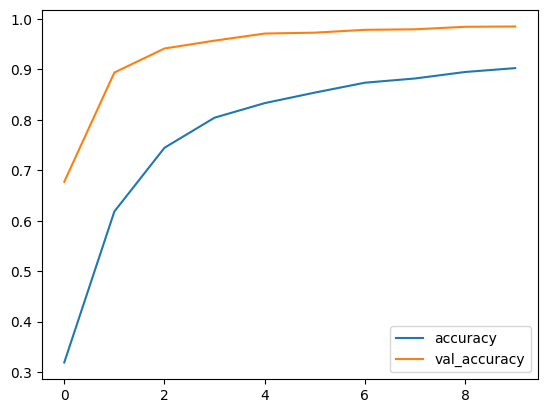

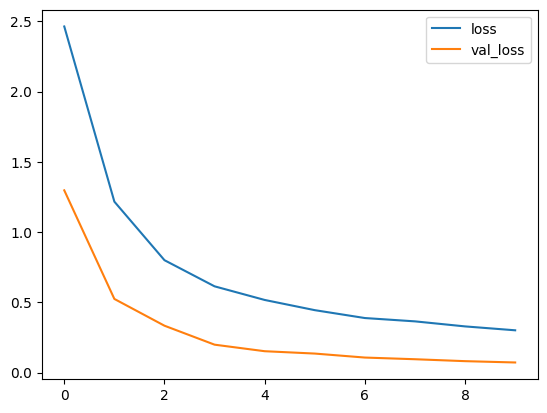

In [22]:
evaluation = pd.DataFrame(model.history.history)
evaluation[['accuracy', 'val_accuracy']].plot()
evaluation[['loss', 'val_loss']].plot()

In [25]:
test_path = 'archive/Test'

In [23]:
from PIL import Image

def scaling(test_images, test_path):
    images = []

    image_path = test_images
    
    for x in image_path:
        img = Image.open(test_path + '/' + x)
        img = img.resize((50,50))
        img = np.array(img)
        images.append(img)

    # Converting images into numpy array
    images = np.array(images)
    images = images/255

    return images

In [30]:
image_extensions = ('.jpg', '.jpeg', '.png')

image_files = [f for f in sorted(os.listdir(test_path)) if f.lower().endswith(image_extensions)]

test_images = scaling(image_files, test_path)

In [31]:
test = pd.read_csv('archive/Test.csv')
y_test = test['ClassId'].values
y_test

array([16,  1, 38, ...,  6,  7, 10])

In [33]:
y_pred = model.predict(test_images)
y_pred

395/395 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step


array([[2.2663878e-16, 7.2028438e-15, 2.2199685e-15, ..., 6.5108451e-17,
        2.0535394e-18, 4.2732579e-13],
       [1.3421969e-07, 9.9998260e-01, 7.3337537e-06, ..., 3.8563571e-20,
        7.2556943e-30, 1.6949727e-29],
       [9.2209842e-37, 4.6596662e-31, 2.0408312e-28, ..., 1.4682118e-14,
        3.6752786e-21, 8.7912416e-22],
       ...,
       [1.0566271e-05, 1.6077274e-03, 1.4969436e-02, ..., 9.5293758e-04,
        1.9673093e-03, 4.1587013e-03],
       [5.3633245e-05, 3.0218906e-04, 1.1913369e-03, ..., 2.6496578e-05,
        3.0722106e-08, 8.2958941e-06],
       [1.7203725e-08, 1.4359277e-06, 2.1660604e-05, ..., 2.7685894e-07,
        8.6545366e-09, 3.4498250e-06]], dtype=float32)

In [34]:
all_lables = ['Speed limit (20km/h)','Speed limit (30km/h)','Speed limit (50km/h)','Speed limit (60km/h)',
              'Speed limit (70km/h)','Speed limit (80km/h)','End of speed limit (80km/h)','Speed limit (100km/h)',
              'Speed limit (120km/h)','No passing','No passing for vechiles over 3.5 metric tons',
              'Right-of-way at the next intersection','Priority road','Yield','Stop','No vechiles',
              'Vechiles over 3.5 metric tons prohibited','No entry','General caution','Dangerous curve to the left',
              'Dangerous curve to the right','Double curve','Bumpy road','Slippery road','Road narrows on the right',
              'Road work','Traffic signals','Pedestrians','Children crossing','Bicycles crossing','Beware of ice/snow',
              'Wild animals crossing','End of all speed and passing limits','Turn right ahead','Turn left ahead',
              'Ahead only','Go straight or right','Go straight or left','Keep right','Keep left','Roundabout mandatory',
              'End of no passing','End of no passing by vechiles over 3.5 metric']

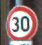

In [35]:
# Visualize test image
img = Image.open(test_path + '/00001.png')
img

In [39]:
y_pred = np.argmax(model.predict(test_images), axis=1)
y_pred = y_pred.astype(int) 

395/395 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step


In [40]:
# Original label
print("Original label : ",all_lables[y_test[1]])

Original label :  Speed limit (30km/h)


In [41]:
# Predicted label
print("Predicted label : ",all_lables[y_pred[1]])

Predicted label :  Speed limit (30km/h)
